In [2]:
import pickle
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
import os


In [3]:
def get_calibration_points(images, nx, ny):
    # Retrieve Object and Image Points from test images
    
    objp = np.zeros((nx*ny,3), np.float32)
    objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2)
    
    object_points = [] # 3-D points in real world space
    image_points = [] # 2-D points in image plane.
    
    # termination criteria
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)
    
    
    # Step through the list and search for chess board corners
    for i, fname in enumerate(images):
        img = cv2.imread(fname)
        
        size = (img.shape[1], img.shape[0])
        #print(size)
        if i == 0:
            image_size = size
        #if size != image_size:
            #raise ValueError("Expected all images to have identical size, but found varying sizes.")
        image_size = size
        
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        # Find the chess board corners
        ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)

        # If found, add object points, image points
        if ret == True:
            object_points.append(objp)
            # refine the corners
            ref_corners = cv2.cornerSubPix(gray,corners,(11,11),(-1,-1),criteria)
            image_points.append(ref_corners)

    return object_points, image_points, image_size 

def calibrate_camera(filepaths, nx, ny):
    # Compute camera matrix and distortion coefficients
    
    # Get the calibration points
    object_points, image_points, image_size = get_calibration_points(filepaths, nx, ny)
    
    # Compute camera calibration given object points and image points
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(object_points, image_points, image_size, None, None)

    # Save the camera calibration result to disk 
    cam_calib = {"cam_matrix": mtx,
                   "dist_coeffs": dist}
    with open("cam_calib.p", "wb") as f:
        pickle.dump(cam_calib, f)
    
    return mtx, dist




In [4]:
def cal_undistort(image, mtx, dist):
    # Function to undistort image given camera matrix coefficicents
    undist = cv2.undistort(image, mtx, dist, None, mtx)

    return undist



In [5]:
def warpImage(img_to_wrap,src_pts,dst_pts,img_size):
    # Transform image to top down view using src_pts and destination pts
    M = cv2.getPerspectiveTransform(src_pts, dst_pts)
    Minv = cv2.getPerspectiveTransform(dst_pts, src_pts)
    warped_img = cv2.warpPerspective(img_to_wrap, M, img_size, flags=cv2.INTER_LINEAR)
        
    
    return warped_img, Minv

In [6]:
# Thresholding to generate a binary image
def abs_sobel_threshold(img, orient='x',sobel_kernel=3, thresh=(0,255)):
    # img in Grayscale
    
    # 2) Take the derivative in x or y given orient = 'x' or 'y'
    if (orient == 'x') :
        sobel_dir = cv2.Sobel(img, cv2.CV_64F, 1, 0) 
    elif (orient=='y') :
        sobel_dir = cv2.Sobel(img, cv2.CV_64F, 0, 1)
        
    sobel_abs=np.absolute(sobel_dir)
    # 4) Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scaled_sobel = np.uint8(255*sobel_abs/np.max(sobel_abs))
    # 5) Create a mask of 1's where the scaled gradient magnitude 
            # is > thresh_min and < thresh_max
    binary_output=np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel > thresh[0]) & (scaled_sobel < thresh[1])] = 1
    
    return binary_output

def mag_threshold(img, sobel_kernel=3, mag_thresh=(0, 255)):
    
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(img, cv2.CV_64F, 1, 0,sobel_kernel) 
    sobely = cv2.Sobel(img, cv2.CV_64F, 0, 1,sobel_kernel)
    
    # 3) Calculate the magnitude 
    abs_sobelxy=np.sqrt(np.square(sobelx) + np.square(sobely))
    # 4) Scale to 8-bit (0 - 255) and convert to type = np.uint8
    scaled_sobel = np.uint8(255*abs_sobelxy/np.max(abs_sobelxy))

    # 5) Create a binary mask where mag thresholds are met
    binary_output=np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel > mag_thresh[0]) & (scaled_sobel < mag_thresh[1]) ] = 1

    return binary_output

def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
  
    # 2) Take the gradient in x and y separately
    sobel_x=cv2.Sobel(img,cv2.CV_64F,1,0,sobel_kernel)
    sobel_y=cv2.Sobel(img,cv2.CV_64F,0,1,sobel_kernel)
    
    # 3) Take the absolute value of the x and y gradients
    abs_sobelx=np.absolute(sobel_x)
    abs_sobely=np.absolute(sobel_y)
    
    #abs_sobelxy=np.sqrt(np.square(sobel_x)+np.square(sobel_y))
    # 4) Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient 
    angle=np.arctan2(np.absolute(sobel_y),np.absolute(sobel_x))
    
    # 5) Create a binary mask where direction thresholds are met
    binary_output=np.zeros_like(angle)
    binary_output[ (angle >= thresh[0]) & (angle <= thresh[1]) ]=1
    # 6) Return this mask as your binary_output image
    #binary_output = np.copy(img) # Remove this line
    return binary_output


In [7]:
# Retrive Image by thresholding on Saturation
def Retrive_Channel_Image(raw_img):
    
    hls = cv2.cvtColor(cv2.imread(raw_img), cv2.COLOR_RGB2HLS)
    H = hls[:,:,0]
    L = hls[:,:,1]
    S = hls[:,:,2]
    
    thresh = (90, 255)
    
    binary = np.zeros_like(S)
    binary[(S > thresh[0]) & (S <= thresh[1])] = 1
    return binary


In [67]:
# Module to search for Lane lines in a picture and fit it to a polynomial
def hist(img):
    # Grab only the bottom half of the image as Lane lines are likely to be mostly vertical nearest to the car
    bottom_half = img[img.shape[0]//2:,400:1000]

    # Sum across image pixels vertically - make sure to set `axis`
    # i.e. the highest areas of vertical lines should be larger values
    histogram = np.sum(bottom_half,axis=0)
    
    return histogram

def first_lane_search(binary_warped):
    
    
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
   
    
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    
    # Find the peak of the left and right halves of the histogram
    # Lanes lines for left needs to be searched between 1/4th to 1/2 of the X scale of histogram
    # Lanes lines for right needs to be searched between 1/2th to 3/4 of the X scale of histogram
    midpoint = np.int(histogram.shape[0]//2)
    
    #Calculate the 1/4th of X-Axis of histogram
    half_midpoint = np.int(midpoint//2)
        
    
    leftx_base = np.argmax(histogram[half_midpoint:midpoint]) + half_midpoint
    rightx_base = np.argmax(histogram[midpoint: (midpoint + half_midpoint) ]) + midpoint
    
    
    

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 11
    # Set the width of the windows +/- margin
    margin = 50
    # Set minimum number of pixels found to recenter window
    minpix = 25

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0]) # indices of Y side as array
    nonzerox = np.array(nonzero[1]) # indices of X side as array
    
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        
        ### Find the four below boundaries of the window ###
        win_xleft_low =  leftx_current - (margin)  
        win_xleft_high = leftx_current + (margin)  
        win_xright_low =  rightx_current - (margin)  
        win_xright_high = rightx_current + (margin)  
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 2) 
        
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0,255,0), 2) 
        
        ### Identify the nonzero pixels in x and y within the window ###
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
         (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
         
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
         (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        ### If you found > minpix pixels, recenter next window ###
        ### (`right` or `leftx_current`) on their mean position ###
        if (len(good_left_inds) > minpix):
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if (len(good_right_inds) > minpix):
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
        

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    # Return a group of points representing a lane curve with image

    return leftx, lefty, rightx, righty, out_img, left_lane_inds, right_lane_inds

def fit_polynomial(binary_warped):
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)

    ### Fit a second order polynomial to each using `np.polyfit` ###
    left_fit = np.polyfit(lefty,leftx,2)
    right_fit = np.polyfit(righty,rightx,2)
    print(right_fit)
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    
    try:
        # Second order Polynomial
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
        
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty

    ## Visualization ##
    # Colors in the left and right lane regions
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]

    # Plots the left and right polynomials on the lane lines
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='red')

    return out_img

In [85]:
# Module to find Lane Lines in sucessive Pictures 
def fit_poly(img_shape, leftx, lefty, rightx, righty):
    
    ### Fit a second order polynomial to each with np.polyfit() 
    left_fit_co = np.polyfit(lefty,leftx,2)
    right_fit_co = np.polyfit(righty,rightx,2)
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, img_shape[0]-1, img_shape[0])
    
    ### Calc both polynomials using ploty, left_fit and right_fit ###
    left_fitx = left_fit_co[2] + left_fit_co[1] * (ploty**1) +  left_fit_co[0] * (ploty**2)
    right_fitx = right_fit_co[2] + right_fit_co[1] * (ploty**1) +  right_fit_co[0] * (ploty**2)
    
    return left_fitx, right_fitx, ploty, left_fit_co, right_fit_co


def search_with_prev_poly(binary_warped, left_fit, right_fit):
    # HYPERPARAMETER
    
    # Width of the margin around the previous polynomial to search
    margin = 80

    # Grab activated pixels
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    ### Set the area of search based on activated x-values ###
    ### within the +/- margin of our polynomial function ###
    
    # Use polynomial coefficients to construct the curve with pixels activated in new image 
    left_poly= left_fit[2] + left_fit[1] * nonzeroy + left_fit[0] * nonzeroy**2
    right_poly= right_fit[2] + right_fit[1] * nonzeroy + right_fit[0] * nonzeroy**2
    
    # Select the indices that fall with search window / Margin
    left_lane_inds = ((nonzerox >= left_poly-margin) & (nonzerox < left_poly+margin)).nonzero()[0]
    right_lane_inds = ((nonzerox >= right_poly-margin) & (nonzerox < right_poly+margin)).nonzero()[0]
    
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # Fit new polynomials
    #left_fitx, right_fitx, ploty = fit_poly(binary_warped.shape, leftx, lefty, rightx, righty)
   
    return leftx, lefty, rightx, righty

def Visualize_search_corridor(binary_warped,left_lane_inds,right_lane_inds,ploty,margin):
    
     ## Visualization ##
    # Create an image to draw on and an image to show the selection window
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                              ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                              ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    
    verts_left = np.array(list(zip(left_fitx.astype(int), ploty.astype(int))))
    verts_right = np.array(list(zip(right_fitx.astype(int), ploty.astype(int))))
    
    cv2.polylines(window_img,[verts_left],False,(255,255,255),thickness=10)
    cv2.polylines(window_img,[verts_right],False,(255,255,255),thickness=10)
    
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    
    
    ## End visualization steps ##
    
    return result
    

In [10]:
# function to calculate curvature of the given curve
def measure_curvature_pixels(img, leftx, lefty, rightx, righty, xm_per_pixel, ym_per_pixel, ploty):
    
      
    left_curverad, right_curverad , cent_dist = ( 0, 0, 0 )
    
    # Point of evaluation of curvature, we will choose the maximum point at bottom of the image
    y_eval = np.max(ploty) * ym_per_pixel
    
    # Grab activated pixels
    nonzero = img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    
    if (len(leftx) != 0 ) and (len(rightx) != 0 ) :
        # Fit polynomials for X , Y of real world coordinates
        left_fit = np.polyfit(lefty * ym_per_pixel, leftx * xm_per_pixel, 2)
        right_fit = np.polyfit(righty * ym_per_pixel, rightx * xm_per_pixel, 2)
               
    
        ##### calculation of R_curve (radius of curvature) of left and right Lane #####
        derv_ist_order = 2 * left_fit[0] * y_eval  + left_fit[1]
        derv_2nd_order = 2 * left_fit[0]
        left_curverad  =   (pow((1.0 + derv_ist_order**2),1.5)) / np.absolute(derv_2nd_order)
    
        derv_ist_order = 2 * right_fit[0] * y_eval + right_fit[1]
        derv_2nd_order = 2 * right_fit[0]
        right_curverad =  (pow((1.0 + derv_ist_order**2),1.5)) / np.absolute(derv_2nd_order)
        
    return left_curverad, right_curverad

# Function to measure Lane Center
def measure_lane_center(img, l_fit_co, r_fit_co, xm_per_pixel):
    
    dist_lane_center = 0.0
    car_pos = img.shape[1]/2 # car center is middle of X length of picture
    y_pos = img.shape[0] # Construct Lane at bottom of Picture 
    
    if (l_fit_co is not None) and (r_fit_co is not None) :
        l_fit_x_pos = l_fit_co[2] + l_fit_co[1] * y_pos +  l_fit_co[0] * (y_pos**2)
        r_fit_x_pos = r_fit_co[2] + r_fit_co[1] * y_pos +  r_fit_co[0] * (y_pos**2)    
        mean_lane_center = (l_fit_x_pos + r_fit_x_pos) / 2         
        dist_lane_center =  (car_pos - mean_lane_center) * xm_per_pixel    
    return dist_lane_center
    


In [40]:
# Function to draw the lane area on the raw image
def draw_lane_cover(undist, binary_warped, left_fit_coeff, right_fit_coeff, Minv):
    
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    
    ploty = np.linspace(0, undist.shape[0]-1, undist.shape[0])
    
    left_fitx= left_fit_coeff[2] + left_fit_coeff[1] * ploty + left_fit_coeff[0] * ploty**2
    right_fitx= right_fit_coeff[2] + right_fit_coeff[1] * ploty + right_fit_coeff[0] * ploty**2

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    cv2.polylines(color_warp, np.int32([pts_left]), False, (0,0,255), 10)
    cv2.polylines(color_warp, np.int32([pts_right]), False, (255,0,0), 10)
    #plt.imshow(warp_zero)

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (undist.shape[1], undist.shape[0])) 
    
    # Combine the result with the original image
    image_with_lane = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
    
    return image_with_lane, color_warp, newwarp

# Draw Lane statistics on a given image
def draw_lane_stats(imgtodraw, lane_radius, dist_center):
    
    image_with_stats = np.copy(imgtodraw)
    img_height = image_with_stats.shape[0]
    
    font = cv2.FONT_HERSHEY_DUPLEX
    font_scale = 1.25
    
    side = 'center'
    
    if dist_center > 0 :
        side = 'right'
    elif dist_center < 0 :
        side = 'left'
    
        
    text_first_line = 'Lane Radius : ' + '{:04.2f}'.format(np.absolute(lane_radius)) + 'm'
    text_second_line = 'Lane center : ' + '{:04.2f}'.format(np.absolute(dist_center)) +' m ' +side +  ' of Car Center '
    
    cv2.putText(image_with_stats, text_first_line, (40,50), font, font_scale, (100,255,100), 2, cv2.LINE_AA)
    cv2.putText(image_with_stats, text_second_line, (40,100), font, font_scale, (100,255,100), 2, cv2.LINE_AA)
    
    return image_with_stats


In [41]:
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        
        #polynomial coefficients for the most recent fit
        #self.current_fit = [np.array([False])]  
        self.current_fit = []
        
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        
        #x values for detected line pixels
        self.allx = None  
        
        #y values for detected line pixels
        self.ally = None
        
        # number of prevpoly entries
        self.n_prevpoly = 0
        
    def add_fit_type(self, fit_coeff, isdetected,n_refresh,n_moving_avg):
        self.detected = False
        
    
        if fit_coeff is not None:
            to_include = True
            if self.best_fit is not None :
                # compute the difference bwteen best fit and new fit
                self.diffs = np.absolute(fit_coeff - self.best_fit)
                if (self.diffs[0] > 0.001 or self.diffs[1] > 1 or self.diffs[2] > 100 and len(self.current_fit) > 0 ) :
                    self.detected = False
                    to_include = False
                else :
                    # can be added to current fit
                    to_include = True
            else :
                # No best fit is there to compare, include it anyway
                to_include = True
            
            if to_include == True :
                self.current_fit.append(fit_coeff)
                if len(self.current_fit) > n_moving_avg :
                    self.current_fit = self.current_fit[len(self.current_fit) - n_moving_avg:]
                
                # Implement weighted Moving Average to give more weightage to recent values
                wts = np.arange(float(len(self.current_fit)),0.0,-1.0)
                self.best_fit =  np.average(self.current_fit, weights=wts, axis=0)
                self.detected = True
        else :
            self.detected = False
            n_fits = len(self.current_fit)
            if  n_fits > 0 :
                self.current_fit = self.current_fit[n_fits - n_moving_avg:0]
            # Reinitialise best Fits
            n_fits = len(self.current_fit)
            
            if n_fits > 0 :
                # Implement weighted Moving Average to give more weightage to recent values
                wts = np.arange(float(n_fits),0.0,-1.0)
                self.best_fit =  np.average(self.current_fit,weights=wts, axis=0)
        
        if isdetected == True :
            self.n_prevpoly = self.n_prevpoly + 1
            if self.n_prevpoly >= n_refresh :
                self.detected = False
                self.n_prevpoly = 0
        
            
                

True

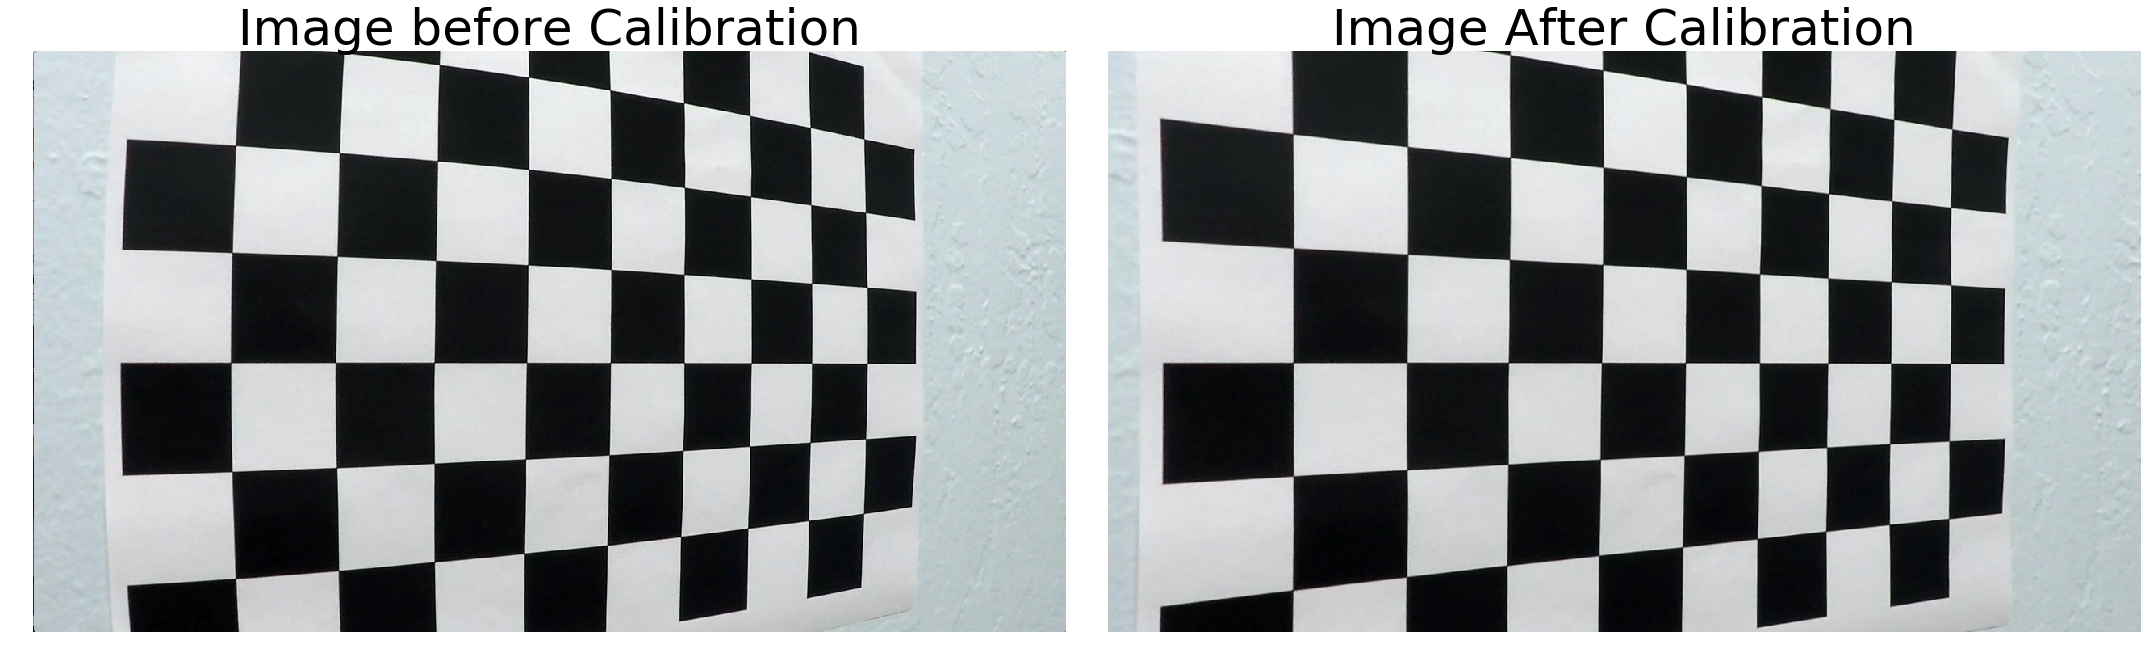

In [93]:
# Code to calibrate camera and test
nx=9
ny=6
ksize=3

# mapping pixels to real world
ym_per_pixel = 3.048 / 100 # Dashed Lane line is 10 ft or 3.048 m
xm_per_pixel = 3.7 / 378  # Lane width in US is 12 ft or 3.7 m

calib_images = glob.glob(os.path.join('camera_cal', 'calibration*.jpg'))
MTX, DIST = calibrate_camera(calib_images,nx,ny)

f, ax = plt.subplots(1, 2, figsize=(30, 40))
f.tight_layout()

img_cv = cv2.imread(calib_images[15])
ax[0].imshow(img_cv)
ax[0].set_title('Image before Calibration', fontsize=50)
cv2.imwrite('output_images/uncalibrated.jpg',img_cv)
ax[0].axis("off")

image_undist = cal_undistort(img_cv,MTX, DIST) 
ax[1].imshow(image_undist)
ax[1].set_title('Image After Calibration', fontsize=50)
ax[1].axis("off")
cv2.imwrite('output_images/calibrated.jpg',image_undist)


True

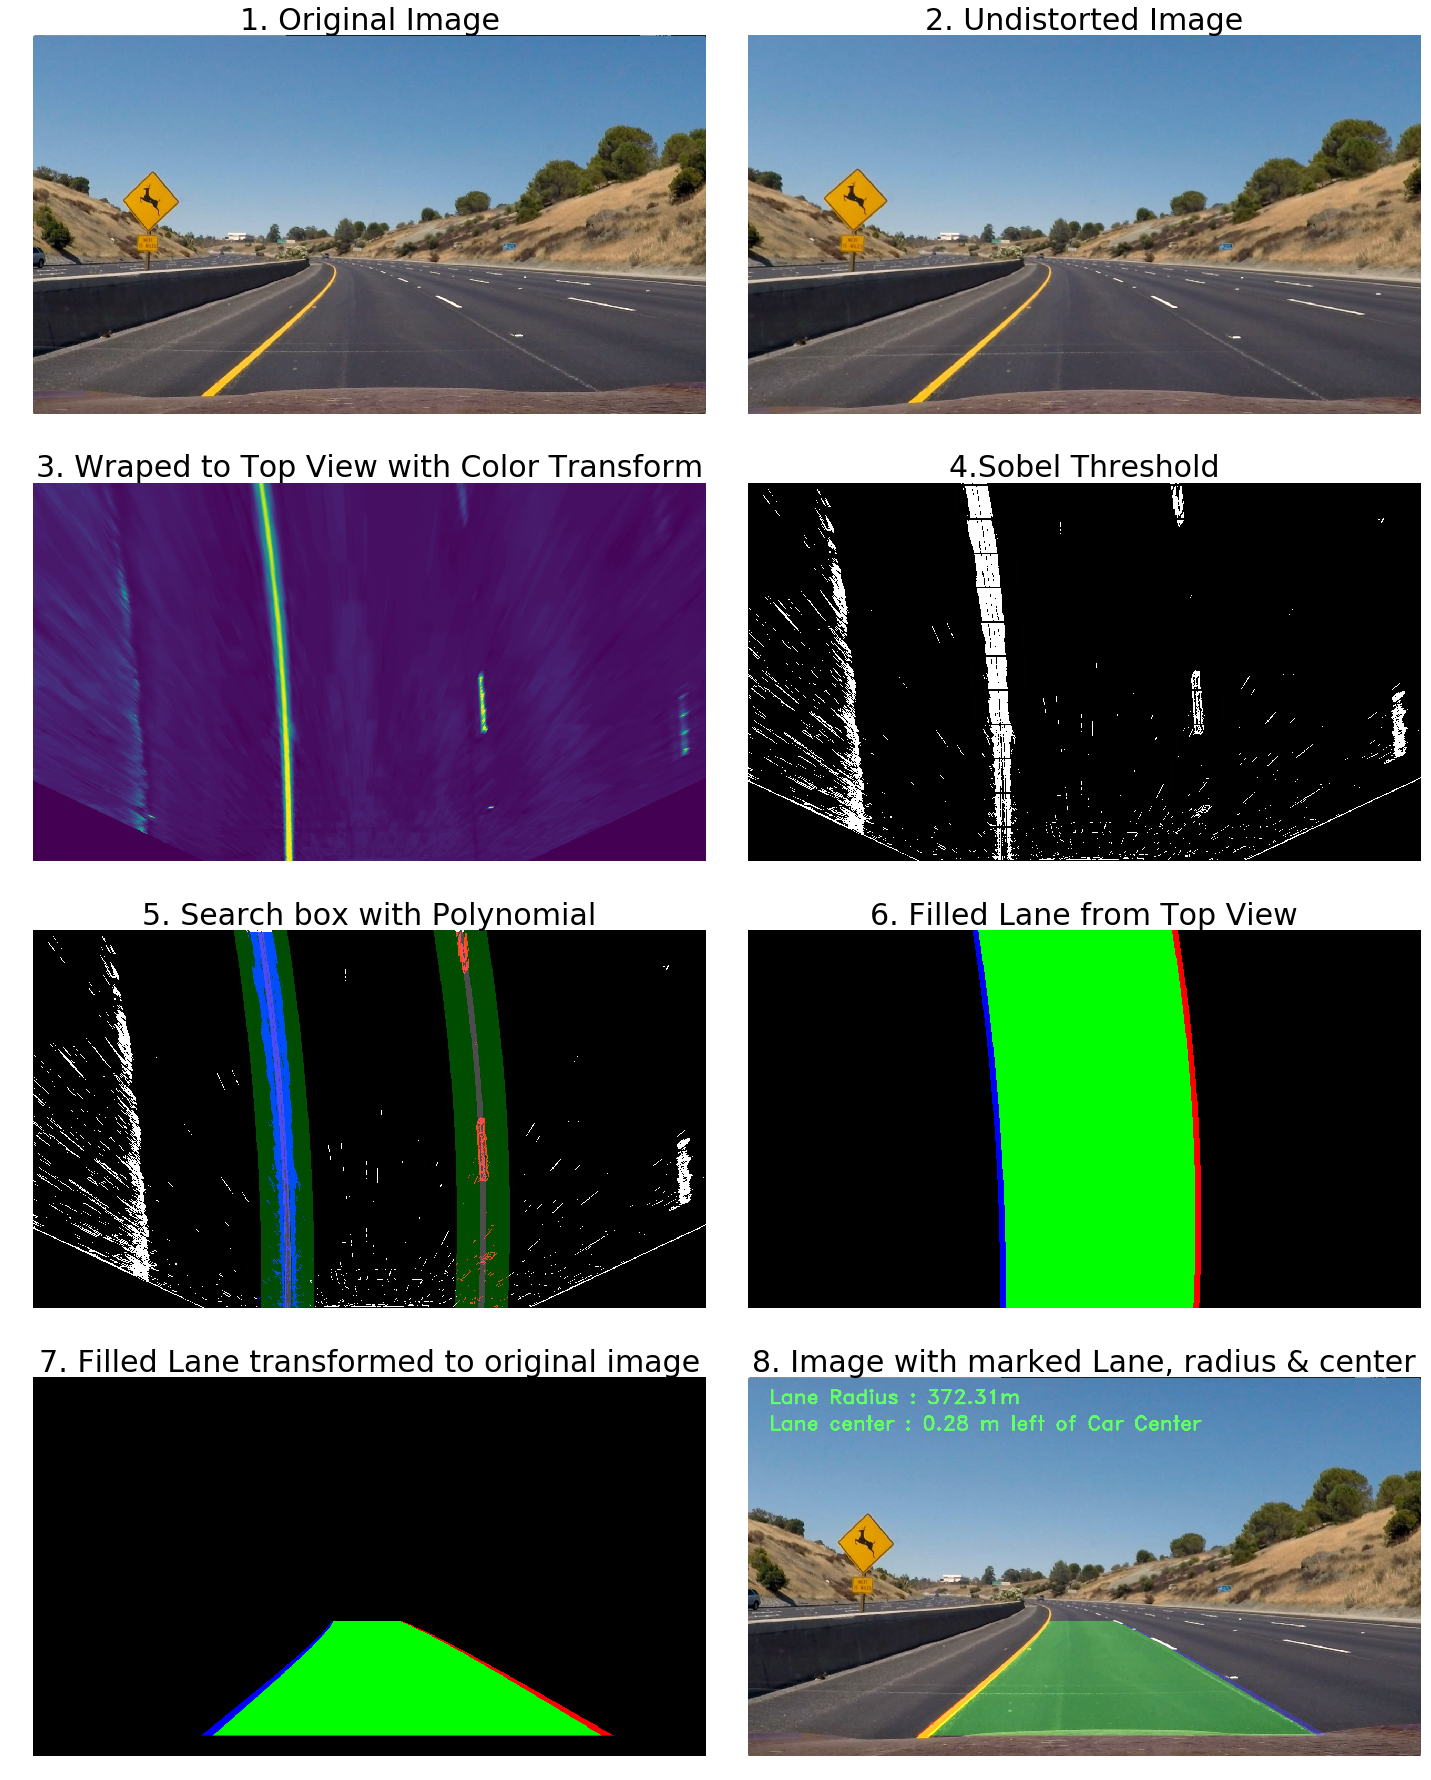

In [92]:
# Test Pipeline on Test images
raw_images = glob.glob(os.path.join('test_images', '*.jpg'))
image_read = cv2.imread(raw_images[7])

image_read2 = cv2.cvtColor(image_read, cv2.COLOR_BGR2RGB)
f, ax = plt.subplots(4, 2, figsize=(20,25))
f.tight_layout()
#plt.imshow(image_read2)
ax[0][0].imshow(image_read2)
ax[0][0].set_title('1. Original Image', fontsize=30)
ax[0][0].axis("off")
cv2.imwrite('output_images/Original_image_1.jpg',image_read2)

def Preprocess_Pipeline_steps(img):
    
    img_width= 0
    img_height= 0
    img_size= (0,0)
    
    image_undistorted = cal_undistort(img, MTX, DIST) 
    ax[0][1].imshow(image_undistorted)
    ax[0][1].set_title('2. Undistorted Image', fontsize=30)
    ax[0][1].axis("off")
    cv2.imwrite('output_images/undistorted_image_2.jpg',image_undistorted)
    
    image_HLS = cv2.cvtColor(image_undistorted, cv2.COLOR_RGB2HLS)
    image_HLS_S = image_HLS[:,:,2]
    
    #image_undistorted = cal_undistort(image_HLS_S, MTX, DIST) 
        
    img_width=image_undistorted.shape[1]
    img_height=image_undistorted.shape[0]
    img_size=(img_width,img_height)
    
    src_pts=np.float32([(575,464),
                    (707,464),
                    (258,682),
                    (1049,682)])

    dst_pts = np.float32([(450,0),
                    (img_width-450,0),
                    (450,img_height),
                    (img_width-450,img_height)])
    
    img_wrap, Minv = warpImage(image_HLS_S,src_pts,dst_pts,img_size)
    
    ax[1][0].imshow(img_wrap)
    ax[1][0].set_title('3. Wraped to Top View with Color Transform', fontsize=30)
    ax[1][0].axis("off")
    cv2.imwrite('output_images/Wraped_image_3.jpg',img_wrap)
    
    image = img_wrap
    grad_bin_x = abs_sobel_threshold(image, orient='x',thresh=(20,95))
    grad_bin_y = abs_sobel_threshold(image, orient='y',thresh=(0,35))
    mag_binary = mag_threshold(image, sobel_kernel=ksize, mag_thresh=(5, 75))
    dir_binary = dir_threshold(image, sobel_kernel=ksize, thresh=(0, np.pi/2))
    combined = np.zeros_like(dir_binary)
    combined[((grad_bin_x == 1) & (grad_bin_y == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1
    
    #ax[1][1].imshow(combined)
    #ax[1][1].set_title('Threshold', fontsize=50)
    
    return combined, Minv, img_size

combined , M_inv, img_size = Preprocess_Pipeline_steps(image_read2)

leftx, lefty, rightx, righty, out_img, left_ind, right_ind = first_lane_search(combined)

ax[1][1].imshow(out_img)
ax[1][1].set_title('4.Sobel Threshold', fontsize=30)
ax[1][1].axis("off")
cv2.imwrite('output_images/Sobel_image_4.jpg',out_img)



left_fitx, right_fitx, ploty, l_fit_co, r_fit_co = fit_poly(img_size, leftx, lefty, rightx, righty)

img_search = Visualize_search_corridor(combined, left_ind, right_ind, ploty,50)
cv2.imwrite('output_images/search_img.jpg',img_search)
ax[2][0].imshow(cv2.cvtColor(cv2.imread('output_images/search_img.jpg'), cv2.COLOR_BGR2RGB))
ax[2][0].set_title('5. Search box with Polynomial', fontsize=30)
ax[2][0].axis("off")
cv2.imwrite('output_images/Search_image_5.jpg',img_search)

left_rad , right_rad = measure_curvature_pixels(combined, leftx, lefty, rightx, righty, xm_per_pixel, ym_per_pixel, ploty)
#print(left_rad)
#print(right_rad)

dist = measure_lane_center(image_read, l_fit_co, r_fit_co, xm_per_pixel)
#print (dist)

[img_with_lane,lane_cover_wraped, lane_cover] = draw_lane_cover(image_read, combined, l_fit_co, r_fit_co, M_inv)
ax[2][1].imshow(lane_cover_wraped)
ax[2][1].set_title('6. Filled Lane from Top View', fontsize=30)
ax[2][1].axis("off")
cv2.imwrite('output_images/Fill_top_image_6.jpg',lane_cover_wraped)

ax[3][0].imshow(lane_cover)
ax[3][0].set_title('7. Filled Lane transformed to original image', fontsize=30)
ax[3][0].axis("off")
cv2.imwrite('output_images/Fill_tranformed_image_7.jpg',lane_cover)

img_with_lane_stats = draw_lane_stats(img_with_lane, (left_rad + right_rad) / 2 ,  dist)

#plt.imshow(img_with_lane_stats)
ax[3][1].imshow(cv2.cvtColor(img_with_lane_stats, cv2.COLOR_BGR2RGB))
ax[3][1].set_title('8. Image with marked Lane, radius & center', fontsize=30)
ax[3][1].axis("off")
cv2.imwrite('output_images/Final_image.jpg',img_with_lane_stats)


In [58]:
# Preprocess image for the Pipeline processing
def Preprocess_Pipeline(img):
    
    img_width= 0
    img_height= 0
    img_size= (0,0)
    
    image_HLS = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    image_HLS_S = image_HLS[:,:,2]
    
    image_undistorted = cal_undistort(image_HLS_S, MTX, DIST) 
        
    img_width=image_undistorted.shape[1]
    img_height=image_undistorted.shape[0]
    img_size=(img_width,img_height)
    
    src_pts=np.float32([(575,464),
                    (707,464),
                    (258,682),
                    (1049,682)])

    dst_pts = np.float32([(450,0),
                    (img_width-450,0),
                    (450,img_height),
                    (img_width-450,img_height)])
    
    img_wrap, Minv = warpImage(image_undistorted,src_pts,dst_pts,img_size)
    
    image = img_wrap
    grad_bin_x = abs_sobel_threshold(image, orient='x',thresh=(20,95))
    grad_bin_y = abs_sobel_threshold(image, orient='y',thresh=(0,35))
    mag_binary = mag_threshold(image, sobel_kernel=ksize, mag_thresh=(5, 75))
    dir_binary = dir_threshold(image, sobel_kernel=ksize, thresh=(0, np.pi/2))
    combined = np.zeros_like(dir_binary)
    combined[((grad_bin_x == 1) & (grad_bin_y == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1
    
    return combined, Minv, img_size

In [94]:
# Definition of Image Pipeline
def process_image_pipeline(image_to_process):
    img_copy = np.copy(image_to_process)
        
    img_comb, M_inverse, img_size = Preprocess_Pipeline(img_copy)
    
    # Global Variable :     line_tracker_Left_Lane / line_tracker_Right_Lane
    
    # set Refresh Rate for Lane search alg 
    n_refresh = 1
    
    # set number of points to consider for Moving average
    n_mvg_avg = 30
    
    #Variable to track which algorithm is used to find lanes
    fromPrevPoly=False
    
    if (line_tracker_Left_Lane.detected == True or line_tracker_Right_Lane.detected == True):
        leftx, lefty, rightx, righty = search_with_prev_poly(img_comb, line_tracker_Left_Lane.best_fit, line_tracker_Right_Lane.best_fit )  
        fromPrevPoly = True
        
    else :
        leftx, lefty, rightx, righty, out_img, left_ind, right_ind = first_lane_search(img_comb)
        fromPrevPoly = False

    left_fitx, right_fitx, ploty, left_lane_coeff, right_lane_coeff = fit_poly(img_size, leftx, lefty, rightx, righty)

    if (left_lane_coeff is not None and right_lane_coeff is not None):
        # Validate the coeffecient by doing a base distance check 
        y_bottom = img_comb.shape[0]
        l_fit_x_bottom = left_lane_coeff[2] + left_lane_coeff[1] * y_bottom + left_lane_coeff[0] * (y_bottom**2)
        r_fit_x_bottom = right_lane_coeff[2] + right_lane_coeff[1] * y_bottom + right_lane_coeff[0] * (y_bottom**2)
        x_bottom_diff = abs(l_fit_x_bottom - r_fit_x_bottom)
        Tol = 380
        if abs(Tol - x_bottom_diff) > 100 :
            left_lane_coeff = None
            right_lane_coeff = None
    
    line_tracker_Left_Lane.add_fit_type(left_lane_coeff, fromPrevPoly, n_refresh, n_mvg_avg)
    line_tracker_Right_Lane.add_fit_type(right_lane_coeff, fromPrevPoly, n_refresh, n_mvg_avg)   
    
    if (line_tracker_Left_Lane.best_fit is not None and line_tracker_Right_Lane.best_fit is not None):
        
        # Calculate Lane radius and distance of car from the center of lane 
        left_rad , right_rad = measure_curvature_pixels(img_comb, leftx, lefty, rightx, righty, xm_per_pixel, ym_per_pixel, ploty)
        c_dist = measure_lane_center(image_read, line_tracker_Left_Lane.best_fit, line_tracker_Right_Lane.best_fit, xm_per_pixel)
        
        #Draw lane cover and stats on the original image
        img_with_lane_cover, colorwrap, colortrans = draw_lane_cover(img_copy, img_comb, line_tracker_Left_Lane.best_fit, line_tracker_Right_Lane.best_fit, M_inv)
        img_with_lane_stats = draw_lane_stats(img_with_lane_cover, (left_rad + right_rad) / 2 ,  c_dist)
    else :
        img_with_lane_stats = img_copy
    
    
    
    return img_with_lane_stats


In [95]:
# Define Tracker object for Left and Right Lane
from moviepy.editor import VideoFileClip
from IPython.display import HTML

line_tracker_Left_Lane = Line()
line_tracker_Right_Lane = Line()
video_to_process = 'project_video_output.mp4'
video_input = VideoFileClip('project_video.mp4')#.subclip(35,45)
video_processed = video_input.fl_image(process_image_pipeline)
%time video_processed.write_videofile(video_to_process, audio=False)



[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


100%|█████████▉| 1260/1261 [04:57<00:00,  4.31it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

CPU times: user 3min 9s, sys: 2.91 s, total: 3min 12s
Wall time: 4min 59s


In [96]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(video_to_process))

In [16]:
# Define Tracker object for Left and Right Lane
from moviepy.editor import VideoFileClip
from IPython.display import HTML

line_tracker_Left_Lane = Line()
line_tracker_Right_Lane = Line()
video_to_process = 'challenge_video_output.mp4'
video_input = VideoFileClip('challenge_video.mp4')#.subclip(35,50)
video_processed = video_input.fl_image(process_image_pipeline)
%time video_processed.write_videofile(video_to_process, audio=False)

[MoviePy] >>>> Building video challenge_video_output.mp4
[MoviePy] Writing video challenge_video_output.mp4


100%|██████████| 485/485 [02:13<00:00,  3.86it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: challenge_video_output.mp4 

CPU times: user 1min 27s, sys: 2.81 s, total: 1min 30s
Wall time: 2min 16s


In [1]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(video_to_process))

NameError: name 'HTML' is not defined

In [92]:
# Define Tracker object for Left and Right Lane
from moviepy.editor import VideoFileClip
from IPython.display import HTML

line_tracker_Left_Lane = Line()
line_tracker_Right_Lane = Line()
video_to_process = 'harder_challenge_video_output.mp4'
video_input = VideoFileClip('harder_challenge_video.mp4')#.subclip(35,50)
video_processed = video_input.fl_image(process_image_pipeline)
%time video_processed.write_videofile(video_to_process, audio=False)

[MoviePy] >>>> Building video harder_challenge_video_output.mp4
[MoviePy] Writing video harder_challenge_video_output.mp4


100%|█████████▉| 1199/1200 [06:50<00:00,  2.87it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: harder_challenge_video_output.mp4 

CPU times: user 4min 10s, sys: 2.97 s, total: 4min 13s
Wall time: 6min 54s


In [94]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(video_to_process))